In [148]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys

In [153]:
# %matplotlib widget
print('loading...')
df = pd.read_csv('../access.csv', names=['timestamp', 'address', 'size', 'action'])


loading...


In [155]:
acc = df[df['action'] == 'lock']
print(acc)

print('computing spans...')
average_spans = {'timestamp': [], 'avg_span': []}
k = 10000 # len(acc['address']) // 500 # number of accesses to measure span over

for i in range(0, len(acc['address']), k):
    dist = 0
    average_spans['timestamp'].append(i)
    last = acc['address'][i]
    for a in acc['address'][i+1:i+k]:
        dist += abs(last - a)
        last = a
    dist /= k
    average_spans['avg_span'].append(dist)
print('plotting...')

scale = 1
fig, ax = plt.subplots(figsize=(21 * scale, 9 * scale))
ax2 = ax.twinx()


def hex_yaxis(g):
    ylabels = [hex(int(x)) for x in g.get_yticks()]
    g.set_yticklabels(ylabels)
    
g = sns.scatterplot(data=acc, x='timestamp', y='address', hue='action', ax=ax,
                marker='.',
                alpha=1,
                linewidth=0,
                palette="muted")
hex_yaxis(g)

g = sns.lineplot(data=pd.DataFrame(average_spans), x='timestamp', y='avg_span', ax=ax2, color='black', alpha=1)
hex_yaxis(g)

plt.grid()
plt.show()

        timestamp          address  size action
1               1  281471975776256   280   lock
2               2  281471975776256   280   lock
3               3  281471975776256   280   lock
4               4  281471975776256   280   lock
5               5  281471975776256   280   lock
...           ...              ...   ...    ...
491061     491061  281471976930784    19   lock
491062     491062  281471976930784    19   lock
491063     491063  281471976930784    19   lock
491064     491064  281471976930784    19   lock
491065     491065  281471976930784    19   lock

[472432 rows x 4 columns]
computing spans...


KeyError: 0

         timestamp          address  size action
0                0  281472823025664  1624  alloc
38              38  281472823054336   720  alloc
147            147  281472823066624    56  alloc
173            173  281472823070720    32  alloc
193            193  281472823066688    56  alloc
...            ...              ...   ...    ...
1232246    1232246  281472823069952    64   free
1232255    1232255  281472823070080    64   free
1232264    1232264  281472823070336    64   free
1232274    1232274  281472823162368  1360   free
1232279    1232279  281472823025664  1624   free

[3786 rows x 4 columns]
281471975772416 281471977061568
address space: 0xffff4d215100-0xffff4d34fcc0 (1289152 bytes)
18635 9.705729166666666


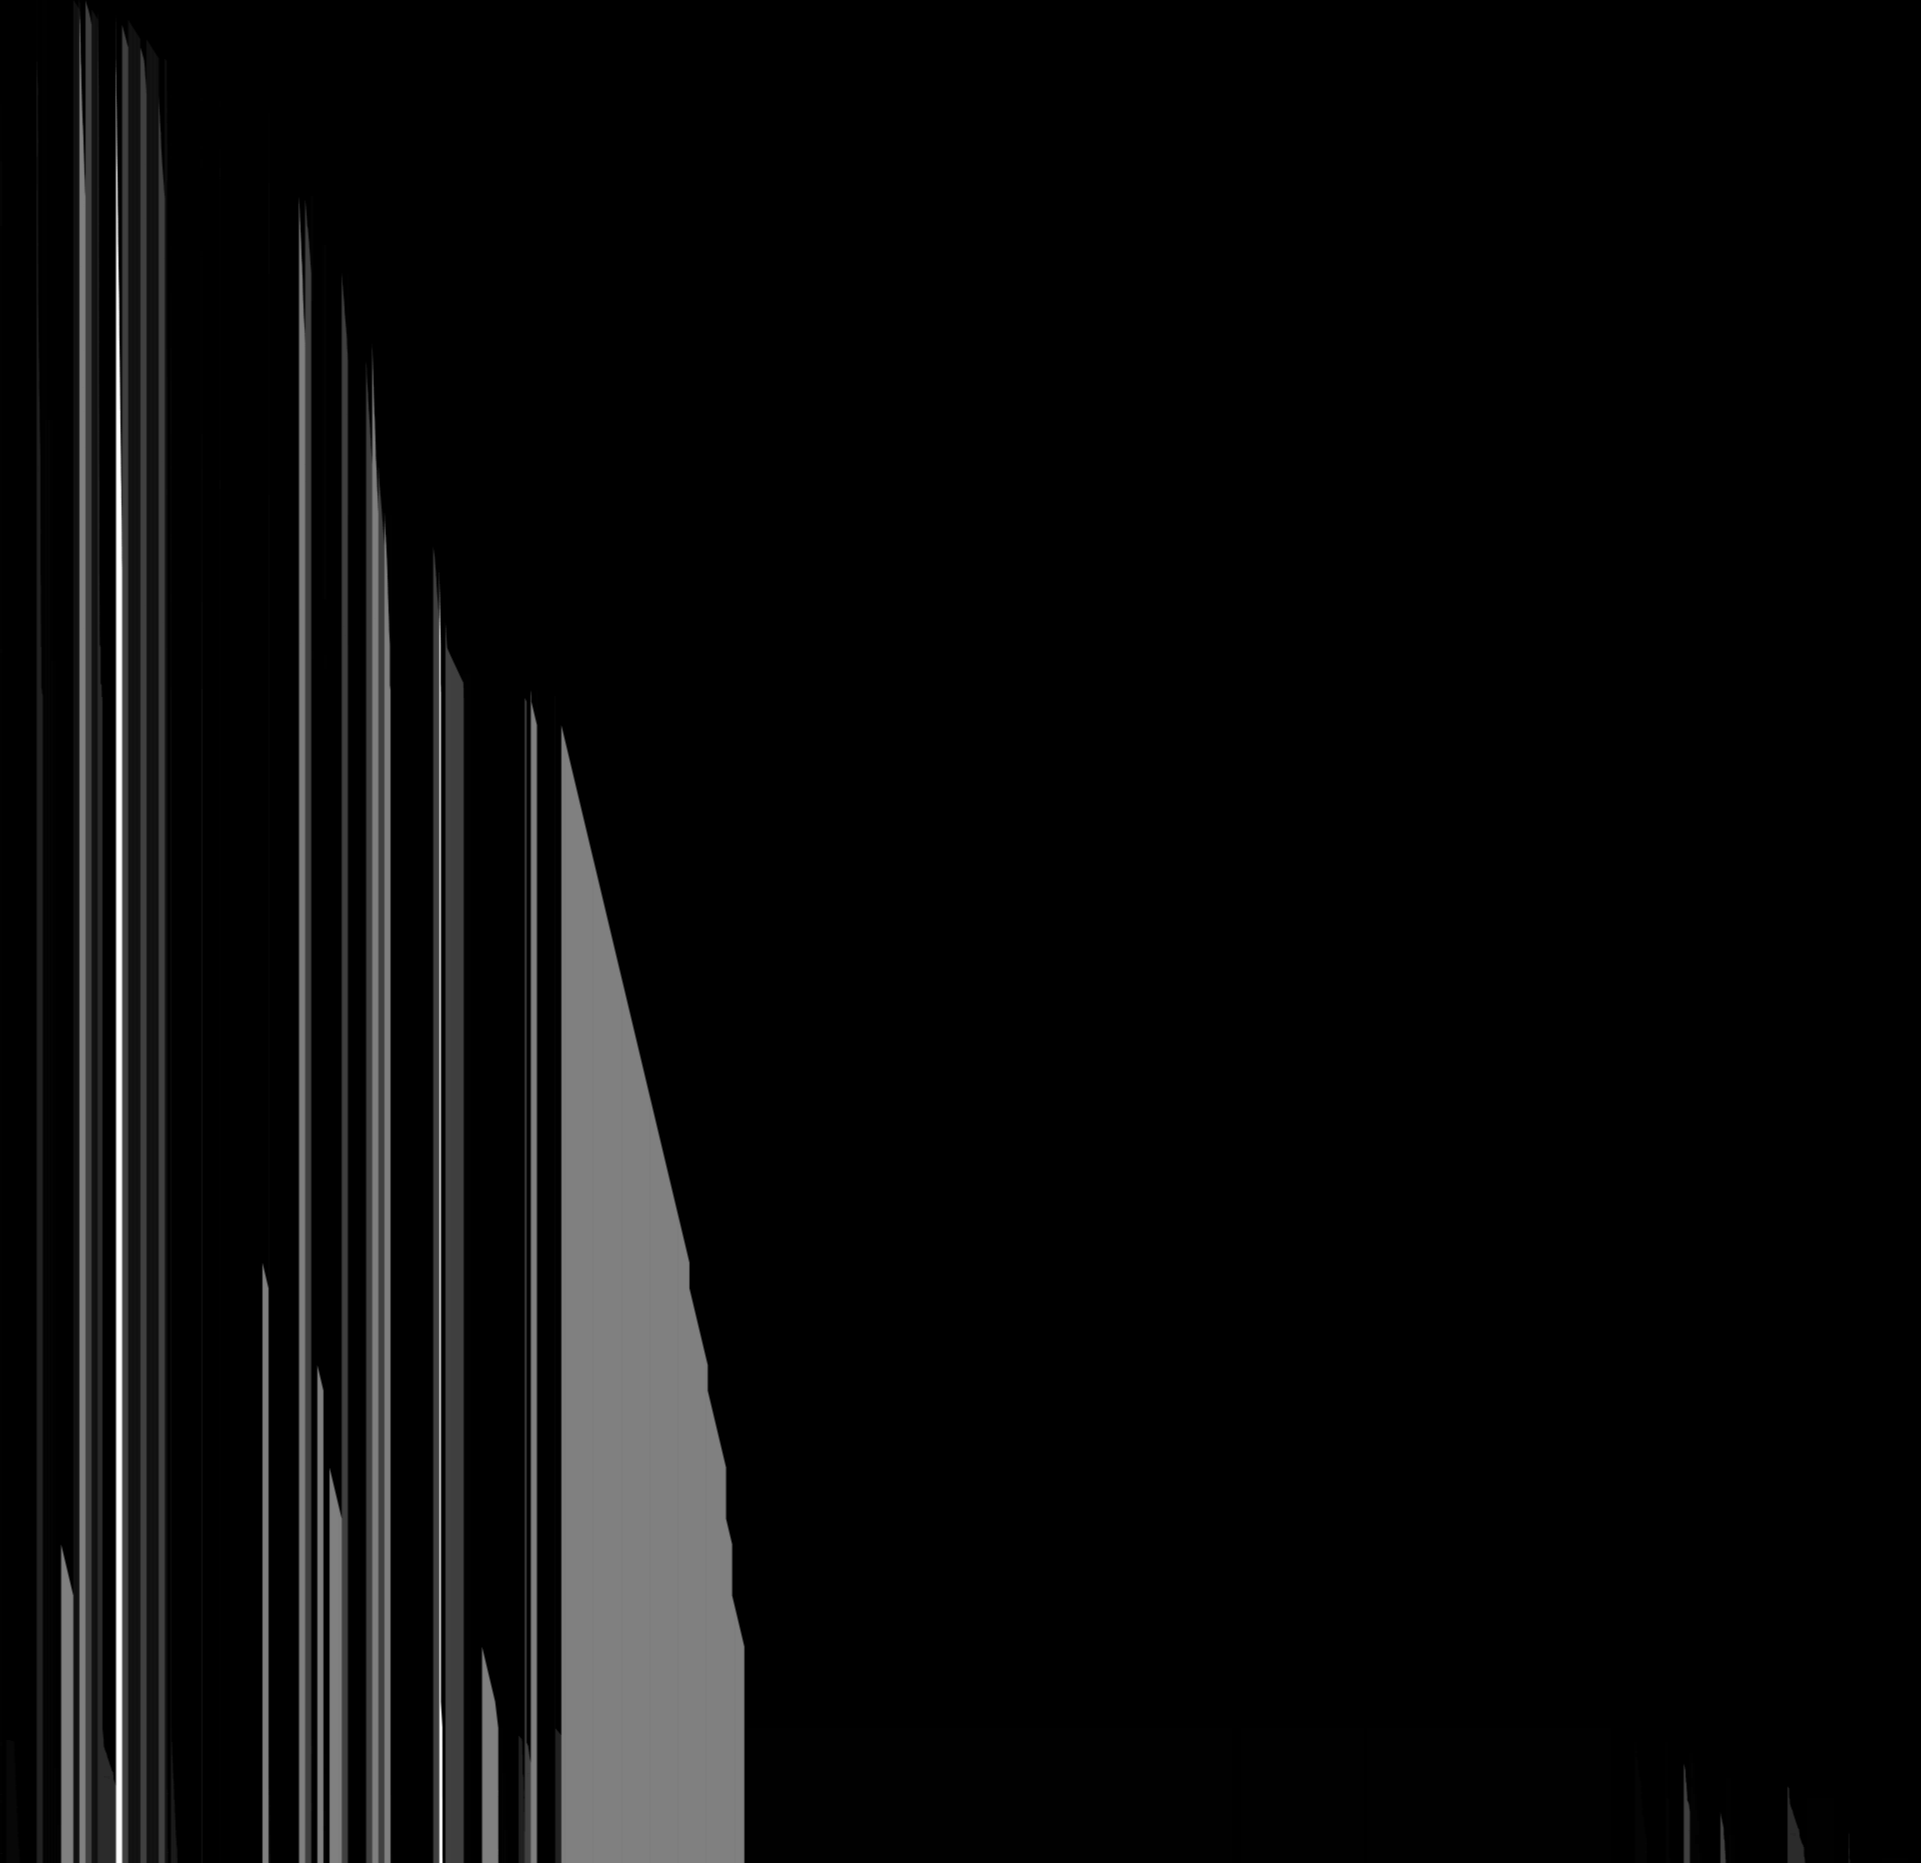

In [154]:
import time
import PIL.Image
from io import BytesIO
import IPython.display
import numpy as np
import math


hp = df[df['action'] != 'lock']
print(heap_actions)

def show_heap(a, fmt='png'):
    a = np.uint8(a)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

max_addr = int(max(df['address']))
min_addr = int(min(df['address']))
print(min_addr, max_addr)

addr_range = max_addr - min_addr

print(f'address space: {hex(min_addr)}-{hex(max_addr)} ({addr_range} bytes)')

width = 1920
heap_timeseries = []


# each cell in the heap represents how many allocations cross into each cell
heap = [0] * (width + 1)

last_b = None

def convert_addr(addr):
    b = (addr - min_addr) / (addr_range)
    b = int(b * width)
    if b >= width:
        b = 0
    if b < 0:
        b = 0
    return b
    
bin_size = len(hp['address']) / width
print(len(hp['address']), bin_size)

current_size = 0
for i, row in hp.iterrows():
    addr, size, action = row['address'], row['size'], row['action']
    delta = 1 if action == 'alloc' else -1
    begin = convert_addr(addr)
    end = convert_addr(addr + size)
    for b in range(begin, end+2):
        heap[b] += delta
    current_size += 1
    if current_size >= bin_size:
        heap_timeseries.append([x if x > 0 else 0 for x in heap])
        current_size = 0

        
def normalized(a):
    return (a-np.min(a))/(np.max(a)-np.min(a))

# display(heap_timeseries)
r = normalized(heap_timeseries) * 255
show_heap(r)